# Koopman operator learning, a toy case: Duffing oscillator

**-- PLEASE SUBMIT YOUR COMPLETED NOTEBOOK WITH CELL OUTPUTS --**


The aim of this notebook is to describe the dynamics of a non-linear dynamical system by means of the Koopman theory.

## Introduction

We consider a quantity $x$ (a vector) which evolves with time, following a dynamical system. Think for example of the joint location of the planets in our solar system, which follows the law of gravitation.

Formally, given an initial state $x(t=0) \in \mathbb{R}^n$ at time $t=0$, the time evolution of $x$ is governed by the following dynamical system:
$$
\dot{x}(t) = f(x(t)) \quad \text(1)
$$

where $\dot{x}(t) := \frac{dx(t)}{dt}$ is the temporal derivative, and $f:\mathbb{R}^n \rightarrow \mathbb{R}^n$ is a given map describing the dynamics.

For a given $f$, it is not always possible to solve the differential equation (1) analytically. For this reason, instead, numerical schemes are usually employed, to integrate in time $t$ the equation (1), so as to propagate the initial condition $x(0)$ up to a desired time $T$; think of $x(T) = x(0) + \int_{t=0}^{T} f(x(t)) dt$. The discretization in time of eq (1) or of the integral introduces numerical approximations, and yields estimates of $x(T)$ of various quality depending on the discretization scheme.

In the field of numerical simulations, discretization schemes have been studied for a long time, and numerical solvers already exist to provide good estimates of integrals (far better than with the naive discretization $x_{k+\delta} = x_k + \delta\,f(x_k)$ for a discrete time increment $\delta$, which induces a $O(\delta^2)$ error at each time step).

The goal of this practical session is to make use of such numerical solvers to improve the learning of dynamical systems with neural networks.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

# arrange the dataset
from sklearn.model_selection import train_test_split

## Duffing oscillator

As a toy example, we consider the Duffing oscillator, where the state $x = (x_1, x_2) \in \mathbb{R}^2$ follows the dynamical system described by the following ODEs:

$$
\dot{x}_1 = x_2\\
\dot{x}_2 = x_1 - x_1^3
$$

To integrate in time the ODEs, a 4th order Runge-Kutta scheme can be used.


In [2]:
def duffing(array_x: np.ndarray) -> np.ndarray:
    array_dx = np.zeros(array_x.shape)
    array_dx[0] = array_x[1]
    array_dx[1] = array_x[0] - array_x[0] ** 3
    return array_dx

In [3]:
t_max = 500  # Time-horizon integration
n_iter = 5000  # Number of time steps integration
n_initial_conditions = 60  # Number of initial conditions

dim_system = 2

# Generate initial conditions
matrix_x0 = (np.random.rand(n_initial_conditions, dim_system) - 0.5) * 4
array_t = np.linspace(0, t_max, n_iter)
array3d_xt = np.zeros((matrix_x0.shape[0], matrix_x0.shape[1], n_iter))

for i in tqdm(range(matrix_x0.shape[0])):
    # Lambda function is used as solve_ivp requires a function of the form f(t, x)
    ode_result = solve_ivp(lambda _t, array_x: duffing(array_x),
                           [0, t_max],
                           matrix_x0[i],
                           method='RK45',
                           t_eval=array_t)

    array3d_xt[i, :] = ode_result.y

100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


The following plot shows trajectories for different initial conditions:

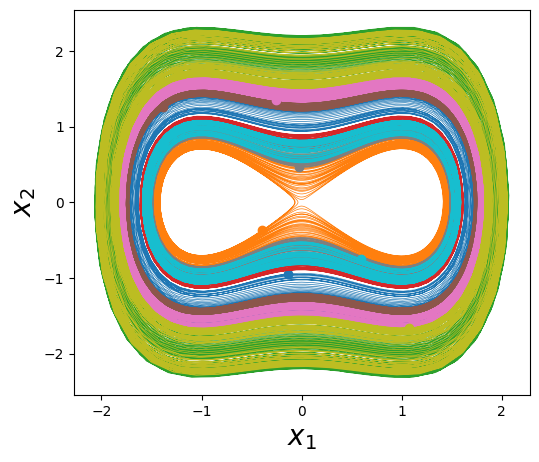

In [4]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131)
cm = plt.get_cmap("tab10")
print(cm)
for i in range(10):
    ax.plot(array3d_xt[i, 0, :], array3d_xt[i, 1, :], lw=0.5, color=cm(i))
    ax.plot(array3d_xt[i, 0, 0], array3d_xt[i, 1, 0], 'o', lw=1.5, color=cm(i))  #initial condition
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
plt.show()

## The Koopman operator
### Discontinuous in time case
Given the discrete non-linear dynamical system

$$
x_{k+1} = F(x_k)
$$

where $F$ might be the $\delta$-discretised flow map of the continuous dynamical system in eq (1) given by

$$
x_{k+1} = F(x_k) := x_k + \int_{k}^{k + \delta} f(x(s))ds
$$

and $X = (x_k)_{k = 0}^N$ the discrete time series of the system state.


The _Koopman_ theory states that there exists an infinite-dimensional linear operator $\mathcal{K}$ that advances in time all observable functions $(g_i)_{i = 1}^m$ given by $g_i: \mathbb{R}^n \rightarrow \mathbb{R}$

$$
\mathcal{K} g_i(x) = g_i \circ F(x)
$$

This way, the non-linear dynamics of $x$, described by $F$, can be turned into a **linear** dynamical system, described by $\mathcal{K}$, acting on another representation space, formed by the observable quantities $g_i(x)$.

Indeed, let $g_i$ be an observable function and denoting ${g_i}_k := g_i(x_k)$, using the previous equation, the time evolution of the observables is given by

$$
{g_i}_{k+1} = g_i(x_{k+1}) = g_i(F(x_k)) = g_i \circ F(x_k) = \mathcal{K} g_i(x_k) = \mathcal{K} {g_i}_k
$$

then, the linearised dynamics of the observables is given by the following equation

$$
{g_i}_{k+1} = \mathcal{K} {g_i}_k
$$


It is then sufficient to find a function $g: \mathbb{R}^n \rightarrow \mathbb{R}^m$ with $m \gg n$ that embeds the state $x$ into a "larger enough" dimensional space $m$ such that the linear operator $\mathcal{K}$ can be inferred by a matrix $\mathbf{K} \in \mathbb{R}^{m \times m}$.

To project back the dynamics from the Koopman space ($\mathbb{R}^m$, where $g(x)$ lives) to the phase space ($\mathbb{R}^n$, where $x$ lives), a supplementary function $\varphi: \mathbb{R}^m \rightarrow \mathbb{R}^n$ is needed. Going from $x$ to the Koopman space and back yields $\varphi \text{ o  } g = $ Id.

Under this condition, the functions $g$, $\varphi$ and $\mathbf{K}$ can be parametrized $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{K}_{\phi}$, and the parameters $\theta$, $\rho$ and $\phi$ can be learned minimizing suitable loss functions.

For this purpose, given a time series $X = \{x_k | k = 1 \ldots N \}$, the following conditions hold:


1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x_k)) - x_k  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{K_{\phi}} g_{\theta} ( x_k ) - g_{\theta} (x_{k+1})  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_k )\right) - x_{k+1} \Vert = 0
     $$

The last three errors can be used as loss functions to train three different neural networks. These different neural networks compose our architecture that can be summarized as in the following sketch:



![architecture](./architecture.png)

In [5]:
# Flatten the trajectories w.r.t. initial conditions
# and only keep data in the form of (dim_system, n_iter * n_initial_conditions)
matrix_x_data = array3d_xt[:, :, :-1].swapaxes(0, 1).reshape(2, -1).T
matrix_x_next_data = array3d_xt[:, :, 1:].swapaxes(0, 1).reshape(2, -1).T

(matrix_x_data_train,
 matrix_x_data_test,
 matrix_x_next_data_train,
 matrix_x_next_data_test) = train_test_split(matrix_x_data,
                                             matrix_x_next_data,
                                             test_size=0.2)

# Cast type to float32
matrix_x_data_train = matrix_x_data_train.astype(np.float32)
matrix_x_data_test = matrix_x_data_test.astype(np.float32)
matrix_x_next_data_train = matrix_x_next_data_train.astype(np.float32)
matrix_x_next_data_test = matrix_x_next_data_test.astype(np.float32)

print(matrix_x_data_train.shape,
      matrix_x_data_test.shape,
      matrix_x_next_data_train.shape,
      matrix_x_next_data_test.shape)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type('torch.DoubleTensor')

batch_size = 2000  # data per batch

tensor2d_x_data_train = torch.from_numpy(matrix_x_data_train).to(device)
tensor2d_x_next_data_train = torch.from_numpy(matrix_x_next_data_train).to(device)
tensor2d_x_data_test = torch.from_numpy(matrix_x_data_test).to(device)
tensor2d_x_next_data_test = torch.from_numpy(matrix_x_next_data_test).to(device)

torch_dataset_train = TensorDataset(tensor2d_x_data_train,
                                    tensor2d_x_next_data_train)

torch_dataset_test = TensorDataset(tensor2d_x_data_test,
                                   tensor2d_x_next_data_test)

train_dataloader = DataLoader(torch_dataset_train,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(torch_dataset_test,
                             batch_size=batch_size,
                             shuffle=True)

# create the models
feature_dim = 2  # dimension of the Duffing oscillator
hidden_layer = 5  # number of hidden layers in g (ENCODER) and \varphi (DECODER)
output_dim = 30  # dimension in Koopman space

In [8]:
class Encoder(nn.Module):
    def __init__(self, list_layer_dim: list):
        super().__init__()
        self.list_layer_dim = list_layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.list_layer_dim) - 1):
            input_dim = self.list_layer_dim[i]
            output_dim = self.list_layer_dim[i + 1]
            self.list_FC.append(nn.Linear(input_dim, output_dim))

    def forward(self, tensor2d_x):
        for i in range(len(self.list_layer_dim) - 2):
            tensor2d_x = F.elu(self.list_FC[i](tensor2d_x))
        return self.list_FC[-1](tensor2d_x)


In [9]:
class Decoder(nn.Module):
    def __init__(self, list_layer_dim: list):
        super().__init__()
        self.list_layer_dim = list_layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.list_layer_dim) - 1, 0, -1):
            input_dim = self.list_layer_dim[i]
            output_dim = self.list_layer_dim[i - 1]
            self.list_FC.append(nn.Linear(input_dim, output_dim))

    def forward(self, tensor2d_x: torch.Tensor):
        for i in range(len(self.list_layer_dim) - 2):
            tensor2d_x = F.elu(self.list_FC[i](tensor2d_x))
        return self.list_FC[-1](tensor2d_x)

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, feature_dim: int, hidden_layer: int, output_dim: int):
        super().__init__()
        list_layer_dim = \
            [output_dim if i == hidden_layer
             else feature_dim + i * (output_dim - feature_dim) // hidden_layer
             for i in range(hidden_layer + 1)]
        self.encoder = Encoder(list_layer_dim)
        self.decoder = Decoder(list_layer_dim)

    def forward(self, tensor2d_x: torch.Tensor):
        tensor2d_x = self.Encoder(tensor2d_x)
        return self.Decoder(tensor2d_x)

The Koopman operator $\mathbf{K}$ (which is linear, and thus a matrix) must have a [spectral radius](https://en.wikipedia.org/wiki/Spectral_radius) $\rho(\mathbf{K})\le 1$. Such condition will provide a stable -or at least a marginally stable- Koopman operator. To fulfill this requirement, we might leverage on the Perron-Frobenius theorem.

The Perron-Frobenius th. states: if $\mathbf{K}$ is a $m \times m$ positive matrix i.e. $k_{ij} > 0$ for $1 \le i,j \le m$, then the following inequality holds:

$$
\min_i \sum_j k_{ij} \le \rho(\mathbf{K}) \le \max_i \sum_j k_{ij}
$$


**Question 1.** : Complete the `KoopmanModule` class to enforce $\rho(\mathbf{K})\le 1$, using the Perron-Frobenius theorem. Check that the initialization fulfills this property.

In [11]:
class KoopmanOperator(nn.Module):
    def __init__(self, koopman_operator_dim: int):
        super().__init__()
        self.koopman_operator_dim = koopman_operator_dim
        # TODO: Complete the KoopmanOperator class

        # Use SVD to build koopman operator
        # Use Perron-Frobenium theorem to enforce spectral radius <= 1
        self.koopman_operator = torch.rand(self.koopman_operator_dim, self.koopman_operator_dim)
        U, _, V, = torch.svd(self.koopman_operator)
        self.koopman_operator = torch.mm(U, V.t())
        k_min, k_max = self.koopman_operator.min(), self.koopman_operator.max()
        self.koopman_operator = (self.koopman_operator - k_min) / (k_max - k_min)
        self.koopman_operator = self.koopman_operator * 1 / self.koopman_operator_dim

        self.koopman_operator = nn.Parameter(self.koopman_operator)
        self.koopman_operator.requires_grad = True



    def forward(self, tensor2d_x: torch.Tensor):
        # First dimension of tensor2d_x is the batch size
        if tensor2d_x.shape[1] != self.koopman_operator_dim:
            sys.exit(f'Wrong Input Features. Please use tensor'
                     f' with {self.koopman_operator_dim} Input Features')
        # TODO: Implement the forward pass
        transformed_x = torch.mm(tensor2d_x, self.koopman_operator.t())
        return transformed_x



dim_observable = 10
koopman_operator = KoopmanOperator(dim_observable)

In [12]:
# TODO: Check the spectrum initialisation
# check if spectral radius <= 1 (the maximum of the absolute values of its eigenvalues)
eigenvalues = torch.linalg.eigvals(koopman_operator.koopman_operator)
print("Is spectral radius <= 1:", eigenvalues.abs().max() <= 1)

Is spectral radius <= 1: tensor(True)


In [13]:
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
koopman_operator = KoopmanOperator(output_dim).to(device)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): Decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


In [14]:
learning_rate_autoencoder = 0.0001
learning_rate_koopman = 0.00001

optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder)

optimiser_koopman = torch.optim.Adam(koopman_operator.parameters(),
                                     lr=learning_rate_koopman)

**Question 2.** : Define a function to compute the loss to be minimized. It should at least include the 3 terms listed above:
- Reconstruction error
- Prediction error in the Koopman space
- Prediction error in the phase space

Because the different objectives outlined by these losses may compete, the training can be difficult. You may try different variations on these losses and comment your findings. In order to improve the training process, one can for instance:
- Add a multiplicative factor in front of each loss component, to balance their importance; how the scales of different losses are related?
- We can refine the loss acting upon the latent space, by using a variational autoencoder approach. This is similar to the Gaussian likelihood used in the first practical (TD1). We want the prediction in the latent space (i.e. the Koopman space) to be a normal distribution $\mathcal{N}(0, 1)$ . Add a corresponding loss for the latent space. Difference to 0 mean and 1 standard deviation must be thus included in the loss;
- Freeze the gradients of one part of the network, for instance the encoder, for one specific objective, using the [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) property. For instance:
```python
criterion = nn.MSELoss()
...
# Compute one part loss_l of the total loss
# First deactivate gradient computation for irrelevant parts of the architecture
for p in autoencoder.encoder.parameters():
    p.requires_grad = False
loss_l = criterion(pred, target)
# Restore the gradient computation
for p in autoencoder.encoder.parameters():
    p.requires_grad = True
...
total_loss = loss_1 + ... + loss_l + ...
```

In [15]:
# TODO: Implement the loss function here
# HINT: See the training process below to identify the different components of the loss
criterion = nn.MSELoss()

def loss_koopman(tensor2d_x: torch.Tensor,
                 tensor2d_x_next: torch.Tensor,
                 tensor2d_decoded_x: torch.Tensor,
                 tensor2d_observable_next: torch.Tensor,
                 tensor2d_koopman_observable_next: torch.Tensor,
                 tensor2d_predict_x_next: torch.Tensor,
                 alphas):

    # Reconstruction error
    # Freeze the part of koopman operator
    for p in koopman_operator.parameters():
      p.requires_grad = False
    loss_recon = criterion(tensor2d_x, tensor2d_decoded_x)
    for p in koopman_operator.parameters():
      p.requires_grad = True

    # Prediction error in Koopman space
    # Freeze the part of decoder
    for p in autoencoder.decoder.parameters():
      p.requires_grad = False
    loss_koop = criterion(tensor2d_koopman_observable_next, tensor2d_observable_next)
    # Normal loss in the latent space
    loss_normal = 0.5 * tensor2d_koopman_observable_next.mean().abs() + 0.5 * (tensor2d_koopman_observable_next.std() - 1).abs()
    for p in autoencoder.decoder.parameters():
      p.requires_grad = True

    # Prediction error in the phase space
    # No need to freeze
    loss_phase = criterion(tensor2d_predict_x_next, tensor2d_x_next)

    total_loss = alphas[0] * loss_recon + alphas[1] * loss_koop + alphas[2] * loss_phase + alphas[3] * loss_normal
    # TODO: Implement the loss function here
    return total_loss


1.   Reconstruction error
$$
\Vert \varphi_\rho (g_\theta(x_k)) - x_k  \Vert = 0
$$
2.   Prediction error in Koopman space
$$
\Vert \mathbf{K_{\phi}} g_{\theta} ( x_k ) - g_{\theta} (x_{k+1})  \Vert = 0
$$
3.   Prediction error in the phase space
$$
\Vert \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_k )\right) - x_{k+1} \Vert = 0
$$


**Question 3.**: The following cell executes the training loop. You can modify it in order to display the different intermediate losses computed in the function `LOSS` above. How do they evolve in time? Justify your final choice.

In [16]:
n_batch = len(train_dataloader)
n_epoch = 20 # To be tuned

# Design loss dynamics
alphas = [0.3, 0.3, 0.2, 0.2]

def train_loop(n_epoch):
  for epoch in range(n_epoch):
      autoencoder.train()
      koopman_operator.train()
      total_train_loss = 0
      total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0

      for tensor2d_batch_x, tensor2d_batch_x_next in train_dataloader:
          tensor2d_batch_x = tensor2d_batch_x.to(device)
          tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

          optimiser_autoencoder.zero_grad()
          optimiser_koopman.zero_grad()

          tensor2d_observable = autoencoder.encoder(tensor2d_batch_x)
          tensor2d_observable_next = autoencoder.encoder(tensor2d_batch_x_next)

          tensor2d_decoded_x = autoencoder.decoder(tensor2d_observable)

          tensor2d_koopman_observable_next = koopman_operator(tensor2d_observable)

          tensor2d_predict_x_next = autoencoder.decoder(tensor2d_koopman_observable_next)

          tensor_loss_val = loss_koopman(tensor2d_batch_x,
                                        tensor2d_batch_x_next,
                                        tensor2d_decoded_x,
                                        tensor2d_observable_next,
                                        tensor2d_koopman_observable_next,
                                        tensor2d_predict_x_next,
                                        alphas)

          tensor_loss_val.backward()
          optimiser_autoencoder.step()
          optimiser_koopman.step()

          if epoch % 1 == 0:
              total_train_loss += tensor_loss_val.item()

      if epoch % 1 == 0:
          print(epoch, total_train_loss)

      if epoch % 10 == 0:
          autoencoder.eval()
          koopman_operator.eval()
          tensor_loss_val = None
          with torch.no_grad():
              total_test_loss = 0
              for tensor2d_batch_x, tensor2d_batch_x_next in test_dataloader:
                  tensor2d_batch_x = tensor2d_batch_x.to(device)
                  tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

                  tensor2d_observable = \
                      autoencoder.encoder(tensor2d_batch_x)
                  tensor2d_observable_next = \
                      autoencoder.encoder(tensor2d_batch_x_next)
                  tensor2d_decoded_x = \
                      autoencoder.decoder(tensor2d_observable)
                  tensor2d_koopman_observable_next = \
                      koopman_operator(tensor2d_observable)
                  tensor2d_predict_x_next = \
                      autoencoder.decoder(tensor2d_koopman_observable_next)

                  tensor_loss_val = loss_koopman(tensor2d_batch_x,
                                                tensor2d_batch_x_next,
                                                tensor2d_decoded_x,
                                                tensor2d_observable_next,
                                                tensor2d_koopman_observable_next,
                                                tensor2d_predict_x_next,
                                                alphas)

              total_test_loss += tensor_loss_val.item()
              print('-' * 50, 'TEST', '-' * 50)
              print(epoch, total_test_loss)
              print('-' * 106)

In [17]:
learning_rate_autoencoder = 0.0001
learning_rate_koopman = 0.00001

autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
koopman_operator = KoopmanOperator(output_dim).to(device)
optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder)
optimiser_koopman = torch.optim.Adam(koopman_operator.parameters(),
                                     lr=learning_rate_koopman)

n_epoch = 20 # To be tuned
# Design loss dynamics
alphas = [0.7, 0.1, 0.1, 0.1]

train_loop(n_epoch)

0 150.51332211494446
-------------------------------------------------- TEST --------------------------------------------------
0 1.2413303852081299
----------------------------------------------------------------------------------------------------------
1 134.9178015589714
2 97.77429586648941
3 86.78643947839737
4 61.355333626270294
5 37.85359334945679
6 28.684677124023438
7 22.535508707165718
8 18.696534022688866
9 16.488702803850174
10 15.009735718369484
-------------------------------------------------- TEST --------------------------------------------------
10 0.11938901245594025
----------------------------------------------------------------------------------------------------------
11 13.80951140075922
12 12.732153713703156
13 11.726267404854298
14 10.773121863603592
15 9.872046835720539
16 9.04203026741743
17 8.314803153276443
18 7.725967235863209
19 7.273662764579058


In [18]:
learning_rate_autoencoder = 0.0001
learning_rate_koopman = 0.00001

autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
koopman_operator = KoopmanOperator(output_dim).to(device)
optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder)
optimiser_koopman = torch.optim.Adam(koopman_operator.parameters(),
                                     lr=learning_rate_koopman)

n_epoch = 20 # To be tuned
# Design loss dynamics
alphas = [0.1, 0.7, 0.1, 0.1]

train_loop(n_epoch)

0 43.59224331378937
-------------------------------------------------- TEST --------------------------------------------------
0 0.3498847484588623
----------------------------------------------------------------------------------------------------------
1 41.4927698969841
2 31.93248525261879
3 24.0273969322443
4 22.789090618491173
5 22.222241550683975
6 21.812130957841873
7 21.332838401198387
8 20.06628328561783
9 16.844168558716774
10 14.236627645790577
-------------------------------------------------- TEST --------------------------------------------------
10 0.11082655191421509
----------------------------------------------------------------------------------------------------------
11 12.400421649217606
12 10.721071556210518
13 8.967102259397507
14 7.658166293054819
15 7.031999748200178
16 6.672698430716991
17 6.417552515864372
18 6.217685993760824
19 6.0385488756001


In [19]:
learning_rate_autoencoder = 0.0001
learning_rate_koopman = 0.00001

autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
koopman_operator = KoopmanOperator(output_dim).to(device)
optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder)
optimiser_koopman = torch.optim.Adam(koopman_operator.parameters(),
                                     lr=learning_rate_koopman)

n_epoch = 20 # To be tuned
# Design loss dynamics
alphas = [0.1, 0.1, 0.7, 0.1]

train_loop(n_epoch)

0 150.52528643608093
-------------------------------------------------- TEST --------------------------------------------------
0 1.2328052520751953
----------------------------------------------------------------------------------------------------------
1 143.86449670791626
2 93.00516307353973
3 74.49755299091339
4 72.6002431511879
5 71.38255232572556
6 70.55910211801529
7 69.92738741636276
8 69.39913231134415
9 68.8963919878006
10 68.39425748586655
-------------------------------------------------- TEST --------------------------------------------------
10 0.566952645778656
----------------------------------------------------------------------------------------------------------
11 67.86878085136414
12 67.27982968091965
13 66.5466690659523
14 65.51117384433746
15 63.61177158355713
16 58.19434475898743
17 34.154208064079285
18 12.170541010797024
19 7.2782383896410465


In [20]:
learning_rate_autoencoder = 0.0001
learning_rate_koopman = 0.00001

autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
koopman_operator = KoopmanOperator(output_dim).to(device)
optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder)
optimiser_koopman = torch.optim.Adam(koopman_operator.parameters(),
                                     lr=learning_rate_koopman)

n_epoch = 20 # To be tuned
# Design loss dynamics
alphas = [0.3, 0.3, 0.3, 0.1]

train_loop(n_epoch)

0 115.46296209096909
-------------------------------------------------- TEST --------------------------------------------------
0 0.9632667899131775
----------------------------------------------------------------------------------------------------------
1 110.56433111429214
2 89.7117355465889
3 68.32864099740982
4 62.907699674367905
5 60.19621941447258
6 58.173910558223724
7 56.32812637090683
8 54.06772592663765
9 49.02508810162544
10 35.989781603217125
-------------------------------------------------- TEST --------------------------------------------------
10 0.24850991368293762
----------------------------------------------------------------------------------------------------------
11 26.84030854701996
12 21.042585358023643
13 16.6150404214859
14 13.33507775515318
15 11.075771406292915
16 9.833755746483803
17 9.03895553201437
18 8.434734977781773
19 7.951932601630688


In [21]:
learning_rate_autoencoder = 0.0001
learning_rate_koopman = 0.00001

autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
koopman_operator = KoopmanOperator(output_dim).to(device)
optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder)
optimiser_koopman = torch.optim.Adam(koopman_operator.parameters(),
                                     lr=learning_rate_koopman)

n_epoch = 20 # To be tuned
# Design loss dynamics
alphas = [0.4, 0.4, 0.1, 0.1]

train_loop(n_epoch)

0 98.3242649435997
-------------------------------------------------- TEST --------------------------------------------------
0 0.8031314611434937
----------------------------------------------------------------------------------------------------------
1 86.56793946027756
2 65.86530631780624
3 58.66261649131775
4 52.53783982992172
5 39.03373210132122
6 24.710728839039803
7 17.948000118136406
8 14.858915083110332
9 13.139626614749432
10 11.999688237905502
-------------------------------------------------- TEST --------------------------------------------------
10 0.09549778699874878
----------------------------------------------------------------------------------------------------------
11 11.141302667558193
12 10.425671711564064
13 9.778873734176159
14 9.161241568624973
15 8.568934142589569
16 8.011689014732838
17 7.526684921234846
18 7.103683620691299
19 6.721952185034752


# Loss Dynamics Summary

| Loss Dynamics | Train Loss | Test Loss |
|-----------------|-----------------|-----------------|
| 0.7, 0.1, 0.1, 0.1    | 7.27    | 0.12    |
| 0.1, 0.7, 0.1, 0.1   | 6.04    | 0.57    |
| 0.1, 0.1, 0.7, 0.1   | 7.28    | 0.57    |
| 0.3, 0.3, 0.3, 0.1   | 7.95    | 0.25    |
| 0.4, 0.4, 0.1, 0.1   | 6.72    | 0.09    |


In [55]:
# TODO: Explain the loss dynamics and justify your design choices

### Rationale of Design Choices

Setting weights (alpha1, alpha2, alpha3, alpha4) for various loss components enables adjusting their impact on the total loss based on the model's needs. This flexibility helps balance reconstruction quality, Koopman mapping accuracy, phase space prediction, and VAE loss (latent space distribution normality).

### Weight Tuning

We tried different combinations of weights, putting more weights on different losses, and then compare the results.

From the table above, it seems that more weights should be given to reconstruction error and prediction error in Koopman space, from the first and the last combinations.

However, we can also notice that, instead of focusing on only one loss from the first two, the model performs better on the test set if the first two losses are both given more weights, as our last combination [0.4, 0.4, 0.1, 0.1] obtained the best result on the test set.

Therefore we choose the last combination as our final design of loss dynamics.


#### Verification

**Question 4.** : We want to ensure the Koopman operator is stable. This can be verified by checking whether its spectral radius $\rho(\mathbf{K})\le 1$. Plot the eigenvalues of the Koopman operator in order to verify the bound on its spectral radius. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

In [25]:
learning_rate_autoencoder = 0.0001
learning_rate_koopman = 0.00001

autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
koopman_operator = KoopmanOperator(output_dim).to(device)
optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder)
optimiser_koopman = torch.optim.Adam(koopman_operator.parameters(),
                                     lr=learning_rate_koopman)

n_epoch = 100 # To be tuned
# Design loss dynamics
alphas = [0.4, 0.4, 0.1, 0.1]

train_loop(n_epoch)

0 98.18292033672333
-------------------------------------------------- TEST --------------------------------------------------
0 0.8174678683280945
----------------------------------------------------------------------------------------------------------
1 93.63468044996262
2 73.86541104316711
3 57.49395275115967
4 44.586447298526764
5 30.079546809196472
6 23.181604251265526
7 19.258775368332863
8 16.728297784924507
9 14.981051929295063
10 13.67614308744669
-------------------------------------------------- TEST --------------------------------------------------
10 0.11008653044700623
----------------------------------------------------------------------------------------------------------
11 12.622809752821922
12 11.72787905484438
13 10.933390520513058
14 10.20985795557499
15 9.535814605653286
16 8.89448631554842
17 8.272887922823429
18 7.684817470610142
19 7.206980854272842
20 6.878732744604349
-------------------------------------------------- TEST ----------------------------------

Is spectral radius <= 1: True


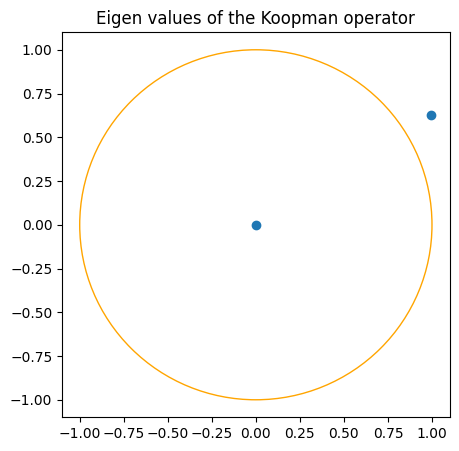

In [26]:
# TODO: Check Koopman stability and plot the eigen values of the Koopman operator against the unit circle

eig_vals = torch.linalg.eigvals(koopman_operator.koopman_operator).cpu().detach().numpy()
print("Is spectral radius <= 1:", np.abs(eig_vals).max() <= 1)

eig_vals_2d = np.column_stack((eig_vals.real,eig_vals.imag))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
circ = plt.Circle((0, 0), radius=1, edgecolor='orange', facecolor='None')
ax.add_patch(circ)
plt.scatter(eig_vals_2d[0], eig_vals_2d[1])
plt.title("Eigen values of the Koopman operator")
plt.show()

In [27]:
n_grid = 30
x1_min, x1_max = -2, 2
x2_min, x2_max = -2, 2

array_x1 = np.linspace(x1_min, x1_max, n_grid, dtype=np.float32)
array_x2 = np.linspace(x2_min, x2_max, n_grid, dtype=np.float32)
matrix_grid_x1, matrix_grid_x2 = np.meshgrid(array_x1, array_x2)

array3d_dynamics = np.zeros((n_grid, n_grid, 2), dtype=np.float32)

for i in range(n_grid):
    for j in range(n_grid):
        x1 = matrix_grid_x1[i, j]
        x2 = matrix_grid_x2[i, j]
        array3d_dynamics[i, j, :] = duffing(np.array([x1, x2]))

# Set evaluation mode
autoencoder.eval()
koopman_operator.eval()

array3d_dynamics_pred = np.zeros((n_grid, n_grid, 2), dtype=np.float32)

for i in range(n_grid):
    for j in range(n_grid):
        x1 = matrix_grid_x1[i, j]
        x2 = matrix_grid_x2[i, j]
        tensor2d_x = torch.tensor([[x1, x2]], dtype=torch.float32).to(device)
        tensor2d_observable = autoencoder.encoder(tensor2d_x)
        tensor2d_koopman_observable_next = koopman_operator(tensor2d_observable)
        tensor2d_predict_x_next = autoencoder.decoder(tensor2d_koopman_observable_next)
        array_x_next = tensor2d_predict_x_next.cpu().detach().numpy().ravel()

        # Here we compute a discretised version of the derivative thanks to the Koopman operator
        # and the learned encoder/decoder

        # (x_{k+1} - x_k) / \delta_t = f(x_k) is approximated by (f is duffing here)
        # (Decod(K(Encod(x_k))) - x_k) / \delta_t

        delta_time = (t_max / n_iter)
        array3d_dynamics_pred[i, j, :] = (array_x_next - [x1, x2]) / delta_time

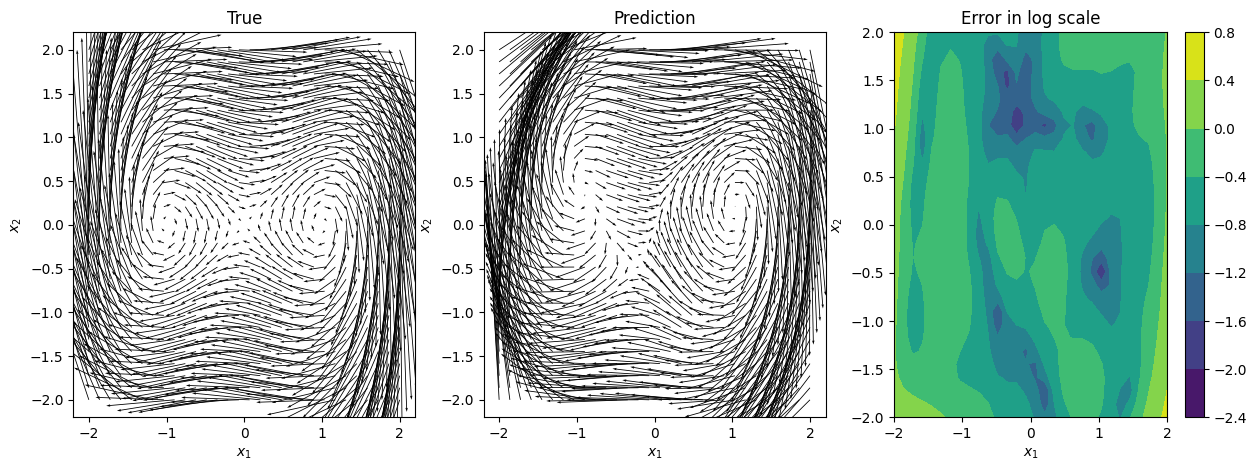

In [28]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.quiver(matrix_grid_x1,
          matrix_grid_x2,
          array3d_dynamics[:, :, 0],
          array3d_dynamics[:, :, 1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(matrix_grid_x1,
          matrix_grid_x2,
          array3d_dynamics_pred[:, :, 0],
          array3d_dynamics_pred[:, :, 1], scale=10)

ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# Compute the error
matrix_error = np.linalg.norm(array3d_dynamics - array3d_dynamics_pred, axis=2)
matrix_error_log = np.log10(matrix_error + 1e-10)

ax = fig.add_subplot(133)
cp = ax.contourf(matrix_grid_x1,
                 matrix_grid_x2,
                 matrix_error_log)

fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

### Continuous in time case

Considering $x_k$ as the observation of a state at time $t = k \delta$, and $x_{k+1}$ the state at time $t+ \delta$, for $\delta \rightarrow 0$  it is also possible to define the continuous-time infinitesimal generator of the Koopman operator family as

$$
\mathcal{L} g (x_k)  = \lim_{\delta \rightarrow 0} \frac{\mathcal{K}g(x_k)- g(x_{k})}{\delta} = \frac{g \circ F (x_k) -x_k}{\delta}
$$

The pevious expression defines the Lie derivative, and for this reason $\mathcal{L}$ is known as the Lie operator. $\mathcal{L}$ describes the continuous dynamics of the observables in the Koopman space:

$$
\dot{g} (x) = \mathcal{L} g(x).
$$

The latter can be further expressed as:

$$
\dot{g} (x(t)) = \frac{dg(x)}{dt} = \nabla_x g \frac{dx}{dt} = \nabla_x g \cdot f(x) =\mathcal{L} g(x).
$$

Given $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{L}_{\phi}$ three parameterized functions, the following conditions hold:

1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x)) - x  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{L_{\phi}} g_{\theta} ( x ) - \nabla g_{\theta} \cdot f(x)  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{L_{\phi}} g_{\theta} ( x )\right) - f(x) \Vert = 0
     $$

**Important Remark: As long as the system $f$ is known, the three errors can be computed without data belonging to trajectories.**

In [29]:
# Create a dataset for continuous Koopman
# with the same amount of points of the Discontinuous Koopman case
# But here no need to have continuous trajectories
matrix_x0 = (np.random.rand(n_initial_conditions * (n_iter - 1), 2) - 0.5) * 4
matrix_system_derivative_data = np.zeros(matrix_x0.shape)
for i in tqdm(range(matrix_x0.shape[0])):
    matrix_system_derivative_data[i, :] = duffing(matrix_x0[i, :])

100%|██████████| 299940/299940 [00:00<00:00, 444739.98it/s]


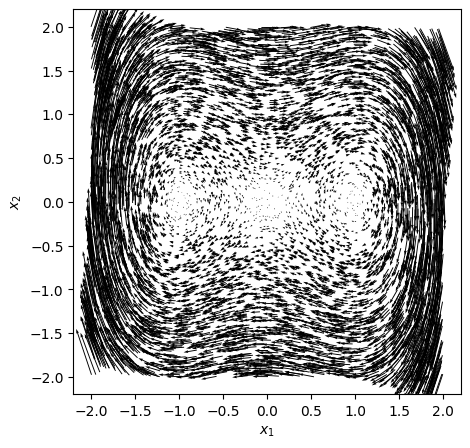

In [30]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.quiver(matrix_x0[::50, 0],
          matrix_x0[::50, 1],
          matrix_system_derivative_data[::50, 0] * 0.2,
          matrix_system_derivative_data[::50, 1] * 0.2, scale=10)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

In [52]:
# create the models
feature_dim = 2  # dimension of the Duffing oscillator
hidden_layer = 5  # number of hidden layers in g (ENCODER) and \varphi (DECODER)
output_dim = 30  # dimension in Koopman space
batch_size = 2000  # data per batch

In [32]:
(matrix_x_data_train,
 matrix_x_data_test,
 matrix_x_next_data_train,
 matrix_x_next_data_test) = train_test_split(matrix_x0,
                                             matrix_system_derivative_data,
                                             test_size=0.2)

# Cast type to float32
matrix_x_data_train = matrix_x_data_train.astype(np.float32)
matrix_x_data_test = matrix_x_data_test.astype(np.float32)
matrix_x_next_data_train = matrix_x_next_data_train.astype(np.float32)
matrix_x_next_data_test = matrix_x_next_data_test.astype(np.float32)

print(matrix_x_data_train.shape,
      matrix_x_data_test.shape,
      matrix_x_next_data_train.shape,
      matrix_x_next_data_test.shape)

torch_dataset_train = TensorDataset(torch.from_numpy(matrix_x_data_train),
                                    torch.from_numpy(matrix_x_next_data_train))
torch_dataset_test = TensorDataset(torch.from_numpy(matrix_x_data_test),
                                   torch.from_numpy(matrix_x_next_data_test))

train_dataloader = DataLoader(torch_dataset_train,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(torch_dataset_test,
                             batch_size=batch_size,
                             shuffle=True)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [33]:
class Encoder(nn.Module):
    def __init__(self, list_layer_dim):
        super().__init__()
        self.list_layer_dim = list_layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.list_layer_dim) - 1):
            dim_input = self.list_layer_dim[i]
            dim_output = self.list_layer_dim[i + 1]
            self.list_FC.append(nn.Linear(dim_input, dim_output))

    def forward(self, tensor2d_x):
        for i in range(len(self.list_layer_dim) - 2):
            tensor2d_x = F.elu(self.list_FC[i](tensor2d_x))
        return self.list_FC[-1](tensor2d_x)

In [34]:
class Decoder(nn.Module):
    def __init__(self, list_layer_dim):
        super().__init__()
        self.list_layer_dim = list_layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.list_layer_dim) - 1, 0, -1):
            dim_input = self.list_layer_dim[i]
            dim_output = self.list_layer_dim[i - 1]
            self.list_FC.append(nn.Linear(dim_input, dim_output))

    def forward(self, tensor2d_x):
        for i in range(len(self.list_layer_dim) - 2):
            tensor2d_x = F.elu(self.list_FC[i](tensor2d_x))
        return self.list_FC[-1](tensor2d_x)

In [35]:
class Autoencoder(nn.Module):
    def __init__(self, feature_dim, hidden_layer, output_dim):
        super().__init__()

        list_layer_dim = \
            [output_dim if i == hidden_layer
             else feature_dim + i * (output_dim - feature_dim) // hidden_layer
             for i in range(hidden_layer + 1)]

        self.encoder = Encoder(list_layer_dim)
        self.decoder = Decoder(list_layer_dim)

    def forward(self, tensor2d_x: torch.Tensor):
        tensor2d_x = self.encoder(tensor2d_x)
        return self.decoder(tensor2d_x)

The Lie operator must be defined such that it will be always stable by construction.
To do that, we consider a matrix of parameters $\Psi \in \mathbb{R}^{m \times m}$ and a vector of parameters $\Gamma \in \mathbb{R}^m$. The resulting Lie operator will be of the form:

$$
\mathbf{L} = (\Psi - \Psi^T) - \text{diag}(\vert \Gamma \vert)
$$

with eigenvalues whose real part $\Re(\lambda) \leq 0$ .
See https://math.stackexchange.com/questions/952233/eigenvalues-of-the-sum-of-a-diagonal-matrix-and-a-skew-symmetric-matrix for the mathematical proof (identify the matrix). Moreover if $\lambda \in \mathbb{C}$ is an eigenvalue of $\mathbf{L}$, it turns out that its real part $\Re(\lambda) \propto \Vert \Gamma \Vert$, i.e. it only depends on $\Gamma$.

Remark: $- \text{diag}(\vert \Gamma \vert)$ is always a diagonal matrix with non-positive elements.


**Question 4.** : As you did for the discrete case, you now have to implement the `LieModule` module. It should have the form indicated above to guarantee $\Re(\lambda) \leq 0$. Check that the initialization fulfills this property.

In [36]:
class LieModule(nn.Module):
    def __init__(self, lie_operator_dim: int):
        super().__init__()
        self.lie_operator_dim = lie_operator_dim
        # TODO: Complete function
        # Build a matrix of parameters and a vector of parameters
        self.lie_matrix = torch.nn.Parameter(torch.randn(self.lie_operator_dim, self.lie_operator_dim))
        # torch.nn.init.kaiming_uniform_(self.lie_matrix, a=np.sqrt(5))
        self.diag = torch.diag(torch.nn.Parameter(torch.randn(self.lie_operator_dim)))

        self.lie_operator = self.lie_matrix - self.lie_matrix.t() - self.diag
        self.lie_operator = nn.Parameter(self.lie_operator)
        self.lie_operator.requires_grad = True

        self.scale = nn.Parameter(torch.ones(1, self.lie_operator_dim))
        self.shift = nn.Parameter(torch.zeros(1, self.lie_operator_dim))

    def forward(self, tensor2d_x: torch.Tensor):
        if tensor2d_x.shape[1] != self.lie_operator_dim:
            sys.exit(f'Wrong Input Features. Please use tensor'
                     f' with {self.lie_operator_dim} Input Features')

        # Enforce the real part of eigenvalues to be non-positive
        lie_operator_norm = self.lie_operator / torch.max(torch.abs(self.lie_operator))
        scaled_lie_operator = -2 * self.scale * lie_operator_norm + self.shift

        # TODO: Implement forward
        return torch.mm(tensor2d_x, scaled_lie_operator.t())

In [37]:
autoencoder = Autoencoder(feature_dim, hidden_layer, output_dim).to(device)
lie_operator = LieModule(output_dim).to(device)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): Decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


Some tricks are needed to train. If the autoencoder and the Lie model are learned at the same speed, the training turns out to be highly unstable since the three loss functions have moving targets. For this reason, the Lie learning rate has been chosen smaller than the autoencoder one.

In [49]:
learning_rate_autoencoder = 0.0001
learning_rate_lie = 0.00001

optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(),
                                         lr=learning_rate_autoencoder,
                                         weight_decay=1e-3)
optimiser_lie = torch.optim.Adam(lie_operator.parameters(),
                                 lr=learning_rate_lie,
                                 weight_decay=1e-3)

A further loss is considered to stabilize the learning stage. The state $x$ belongs to a compact set, since it is the solution of a dissipative dynamical system. This is not true for $g(x)$ (we need to choose appropriate activation functions to have appropriate Liptchitz guarantees). To avoid discrepancies in magnitudes of $g_i(x)$, a regularization loss is added:

$$
\mu = \frac{1}{m} \sum_m g_i(x) = 0  \quad \text{and} \quad  \sigma = \left( \frac{1}{m}\sum_m(g_i(x)-\mu)^2 \right)^{1/2} = 1
$$

inspired by VAE.

For the training to be smooth, the encoder parameters are not affected by the **prediction loss in phase space**. This is based on an empirical observation and is motivated by the fact that the encoder appears in the three losses and plays a competitive role against the decoder and the Lie model. This should not affect the results since the encoder remains coupled with the decoder in the **reconstruction loss** and with the Lie operator in the **prediction loss in Koopman space**.

**Question 5.** : Implement the loss function similarly to what you did for the **Question 2.** Note that here you should use the dynamics $f$ and its values for a set of points belonging to the domain $\left[ -2, 2 \right]^2$ while no data from proper **trajectories** are needed.

In [50]:
# Implement the loss function here
# See the training process below to identify the different components of the loss
def loss(tensor2d_x: torch.Tensor,
         tensor2d_x_next: torch.Tensor,
         tensor2d_decoded_x: torch.Tensor,
         tensor2d_observable_next: torch.Tensor,
         tensor2d_lie_observable_next: torch.Tensor,
         tensor2d_predict_x_next: torch.Tensor,
         tensor2d_jvp: torch.Tensor):

    criterion = nn.MSELoss()

    # Reconstruction error
    for p in lie_operator.parameters():
      p.requires_grad = False
    loss_recon = criterion(tensor2d_x, tensor2d_decoded_x)
    for p in lie_operator.parameters():
      p.requires_grad = True

    # Prediction error in Koopman space
    for p in autoencoder.decoder.parameters():
      p.requires_grad = False
    loss_koop = criterion(tensor2d_lie_observable_next, tensor2d_jvp)
    for p in autoencoder.decoder.parameters():
      p.requires_grad = True

    # Prediction error in the phase space
    # Encoder parameters not affect
    for p in autoencoder.encoder.parameters():
      p.requires_grad = False
    loss_phase = criterion(tensor2d_predict_x_next, tensor2d_x_next)
    for p in autoencoder.encoder.parameters():
      p.requires_grad = True

    # Regularization loss (observables)
    loss_reg = 0.5 * tensor2d_observable_next.mean().abs() + 0.5 * (tensor2d_observable_next.std() - 1).abs()


    total_loss = 0.4 * loss_recon + 0.4 * loss_koop + 0.1 * loss_phase + 0.1 * loss_reg

    return total_loss

**Since trajectories are not needed**, random states can be sampled from the system manifold $x_1 \in [-2, 2]$, $x_2 \in [-2, 2]$.

In [51]:
n_batch = len(train_dataloader)
n_epoch = 100 # To be tuned

for epoch in range(n_epoch):
    autoencoder.train()
    lie_operator.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
    for tensor2d_batch_x, tensor2d_batch_x_next in train_dataloader:
        tensor2d_batch_x = tensor2d_batch_x.to(device)
        tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

        optimiser_autoencoder.zero_grad()
        optimiser_lie.zero_grad()

        # dgX = lie_operator * gX
        # jvp = \nabla_x g (x) * f(x) (jvp: jacobian vector product)
        (tensor2d_observable, tensor2d_jvp) = \
            autograd.functional.jvp(autoencoder.encoder,
                                    tensor2d_batch_x,
                                    tensor2d_batch_x_next,
                                    create_graph=True)

        tensor2d_decoded_x = autoencoder.decoder(tensor2d_observable)

        tensor2d_lie_observable_next = lie_operator(tensor2d_observable)
        tensor2d_predict_x_next = autoencoder.decoder(tensor2d_lie_observable_next)

        tensor_loss_val = \
            loss(tensor2d_x=tensor2d_batch_x,
                 tensor2d_x_next=tensor2d_batch_x_next,
                 tensor2d_decoded_x=tensor2d_decoded_x,
                 tensor2d_observable_next=tensor2d_observable,
                 tensor2d_lie_observable_next=tensor2d_lie_observable_next,
                 tensor2d_predict_x_next=tensor2d_predict_x_next,
                 tensor2d_jvp=tensor2d_jvp)

        tensor_loss_val.backward()
        optimiser_autoencoder.step()
        optimiser_lie.step()

        if epoch % 1 == 0:
            total_train_loss += tensor_loss_val.item()
    if epoch % 1 == 0:
        print(epoch, total_train_loss)

    if epoch % 10 == 0:
        autoencoder.eval()
        lie_operator.eval()
        with torch.no_grad():
            total_test_loss = 0
            total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
            for tensor2d_batch_x, tensor2d_batch_x_next in test_dataloader:
                tensor2d_batch_x = tensor2d_batch_x.to(device)
                tensor2d_batch_x_next = tensor2d_batch_x_next.to(device)

                (tensor2d_observable, tensor2d_jvp) = \
                    autograd.functional.jvp(autoencoder.encoder,
                                            tensor2d_batch_x,
                                            tensor2d_batch_x_next,
                                            create_graph=True)
                tensor2d_decoded_x = autoencoder.decoder(tensor2d_observable)

                tensor2d_lie_observable_next = lie_operator(tensor2d_observable)
                tensor2d_predict_x_next = autoencoder.decoder(tensor2d_lie_observable_next)

                tensor_loss_val = \
                    loss(tensor2d_x=tensor2d_batch_x,
                         tensor2d_x_next=tensor2d_batch_x_next,
                         tensor2d_decoded_x=tensor2d_decoded_x,
                         tensor2d_observable_next=tensor2d_observable,
                         tensor2d_lie_observable_next=tensor2d_lie_observable_next,
                         tensor2d_predict_x_next=tensor2d_predict_x_next,
                         tensor2d_jvp=tensor2d_jvp)

                total_test_loss += tensor_loss_val.item()
            print('-' * 50, 'TEST', '-' * 50)
            print(epoch, total_test_loss)
            print('-' * 106)

0 2.9279599022120237
-------------------------------------------------- TEST --------------------------------------------------
0 0.7137339450418949
----------------------------------------------------------------------------------------------------------
1 2.8160586021840572
2 2.7287962660193443
3 2.617010347545147
4 2.4795714113861322
5 2.3140790462493896
6 2.1174416188150644
7 1.8864713618531823
8 1.6183295734226704
9 1.3160955756902695
10 0.9850583514198661
-------------------------------------------------- TEST --------------------------------------------------
10 0.2054461957886815
----------------------------------------------------------------------------------------------------------
11 0.6584810321219265
12 0.5437898812815547
13 0.4939963535871357
14 0.45573775307275355
15 0.4251536091323942
16 0.4009070268366486
17 0.3816440652590245
18 0.36336651630699635
19 0.3477433198131621
20 0.3358012302778661
-------------------------------------------------- TEST --------------------


### Verification

**Question 6.** : As in the **Question 3.** we want to ensure the Lie operator is stable. This can be verified by checking that the real part of the eigenvalues is negative. Plot the relevant eigenvalues of the Lie operator. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

In [53]:
# TODO: Check the eigenvalues real part
eig_vals = torch.linalg.eigvals(lie_operator.lie_operator).cpu().detach().numpy()
eig_vals_real = eig_vals.real
print("Eigen values Real Part:", eig_vals_real)

Eigen values Real Part: [ 0.6056279   0.6056279   0.08157492  0.08157492 -0.33613658 -0.33613658
  0.03473663  0.03473663  0.08529723  0.08529723  0.07238662  0.07238662
  0.22990417  0.22990417  0.23433697  0.23433697  0.07183101  0.07183101
  0.00164926  0.00164926  0.09250021  0.09250021  0.15348232  0.15348232
  0.31782207  0.31782207  0.11361215  0.11361215  0.18184207  0.18184207]


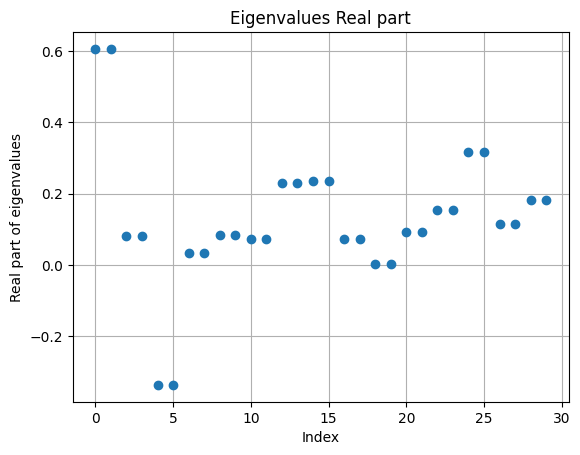

In [54]:
# TODO: Plot the eigenvalues
plt.plot(np.real(eig_vals_real), marker='o', linestyle='None')
plt.xlabel('Index')
plt.ylabel('Real part of eigenvalues')
plt.title('Eigenvalues Real part')
plt.grid(True)
plt.show()

In [55]:
n_grid = 30
array_x1 = np.linspace(x1_min, x1_max, n_grid, dtype=np.float32)
array_x2 = np.linspace(x2_min, x2_max, n_grid, dtype=np.float32)
matrix_grid_x1, matrix_grid_x2 = np.meshgrid(array_x1, array_x2)

array3d_dynamics = np.zeros((n_grid, n_grid, 2))

for i in range(n_grid):
    for j in range(n_grid):
        array3d_dynamics[i, j, :] = duffing(np.array([matrix_grid_x1[i, j], matrix_grid_x2[i, j]]))

autoencoder.eval()
lie_operator.eval()
array3d_dynamics_pred = np.zeros((n_grid, n_grid, 2))
for i in range(n_grid):
    for j in range(n_grid):
        x1 = matrix_grid_x1[i, j]
        x2 = matrix_grid_x2[i, j]
        tensor2d_x = torch.tensor([[x1, x2]], dtype=torch.float32).to(device)
        tensor2d_observable = autoencoder.encoder(tensor2d_x)
        tensor2d_lie_observable_next = lie_operator(tensor2d_observable)
        tensor2d_predict_x_next = autoencoder.decoder(tensor2d_lie_observable_next)
        array_x_next = tensor2d_predict_x_next.cpu().detach().numpy().ravel()

        array3d_dynamics_pred[i, j, :] = array_x_next


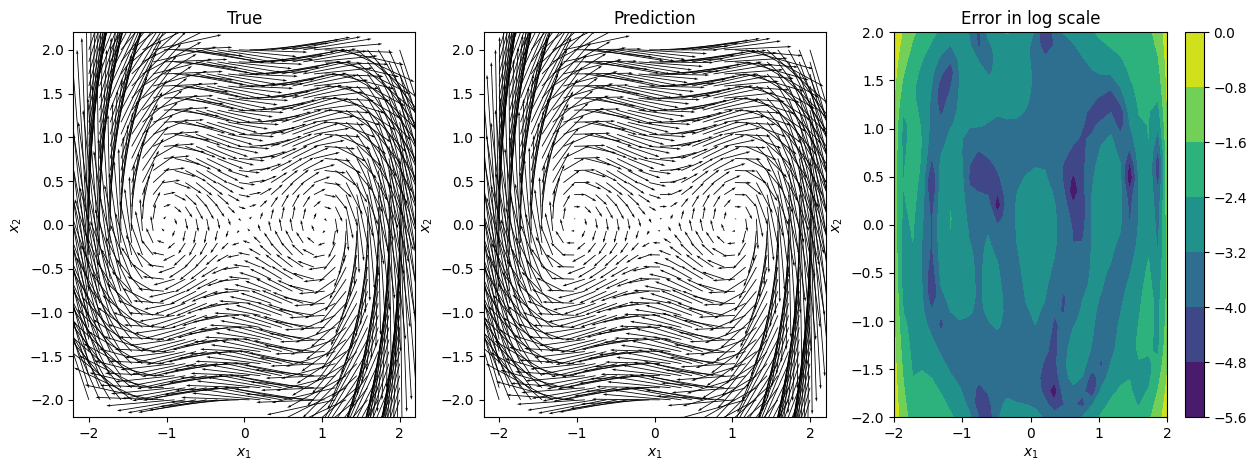

In [56]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.quiver(matrix_grid_x1, matrix_grid_x2, array3d_dynamics[:, :, 0], array3d_dynamics[:, :, 1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(matrix_grid_x1, matrix_grid_x2, array3d_dynamics_pred[:, :, 0], array3d_dynamics_pred[:, :, 1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(matrix_grid_x1, matrix_grid_x2,
                 np.log(np.linalg.norm(array3d_dynamics - array3d_dynamics_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

**Question 7.** : Compare and comment below the two approaches (discrete vs continuous operator).

From the plots of two different approaches, it is clear that the continuous operator has obtained a better result than the discrete one.

Moreover, the comparison bettwen the error plots also reveal that our predition with a continuous operator is more accurate.

The continuous operator performs better might probably because the lie operator is more stable than the Koopman operator.

The comparison of stability between these two operators could be also observed from the plots we had above. It is clear that the real value of the lie operator's eigenvalues is below or very close to zero, while the spectral radius of the Koopman operator is a bit far from zero.

**Question 8.** : Mention one of the important research paper related to this framework. Namely, _deep learning of dynamical systems with the Koopman operator_. Explain shortly the reason of your choice.

The research paper our group selected is

"Learning Compositional Koopman Operators for Model-Based Control"

http://koopman.csail.mit.edu/

This paper proposed a smart approach to learn compositional Koopman operators with graph neural networks to encode the state into object-centric embeddings, and using a block-wise linear transition matrix to regularize the shared structure across objects.

This study is very crucial and especially helpful for us is that its approach allows for quick adaptation to new environments with unkown physical parameters and the production of control signals for specified goals.

Moreover, it deals with scenarios where the number of objects is variable, which is a limitation in current approaches that assume a fixed dimensional state space.

We found this very useful and thus choose this paper to learn from.


**-- PLEASE SUBMIT YOUR COMPLETED NOTEBOOK WITH CELL OUTPUTS --**